The goal is to predict the price of an AirBnB apartment knowing descriptin, type of appartment and neighborhood

In [1]:
#as some executions are too long, code will be writen as comenst, obtained results are stored in pickle
import pickle

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import re
from matplotlib import style
style.use('fivethirtyeight')
import time

In [3]:
data = pd.read_csv('AB_NYC_2019.csv')
data.dropna(how='all')
print(data.shape)
data.head()

(48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


# Data Exploration and Pre-processing

In [4]:
data.isna().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [5]:
#get rid of NaN values, replasing them with 0
data[['last_review','reviews_per_month']] = data[['last_review','reviews_per_month']].fillna(0)

In [6]:
data[data.price<10]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
23161,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,4,1,2018-01-06,0.05,4,28
25433,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,2,55,2019-06-24,2.56,4,127
25634,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,2,16,2019-05-18,0.71,5,0
25753,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,2,12,2017-10-27,0.53,2,0
25778,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,5,3,2018-01-02,0.15,1,73
25794,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,1,93,2019-06-15,4.28,6,176
25795,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,1,95,2019-06-21,4.37,6,232
25796,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,1,95,2019-06-23,4.35,6,222
26259,20933849,the best you can find,13709292,Qiuchi,Manhattan,Murray Hill,40.75091,-73.97597,Entire home/apt,0,3,0,0,0.00,1,0
26841,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,30,2,2019-06-22,0.11,6,333


In [7]:
data = data[data['price']>=10]

In [8]:
min_nights = data.groupby(data['minimum_nights']).count()['id']
print(min_nights.groupby(min_nights.index // 31).sum())
#we can see that after 30'minimum nights' have outliers, i will replase them with 31
data['minimum_nights'] = data['minimum_nights'].apply(lambda x: x if x<=31 else 31)

minimum_nights
0     48137
1       415
2       138
3        57
4        10
5        52
6         8
7         5
8         5
9         7
11       38
12        1
15        1
16        5
32        4
40        1
Name: id, dtype: int64


<a list of 50 Patch objects>

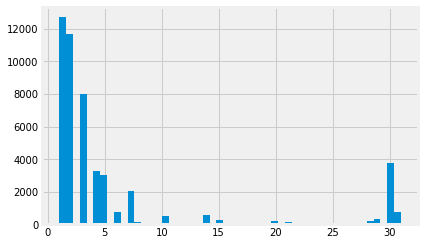

In [9]:
plt.hist(data['minimum_nights'],bins = 50)[2]

<a list of 100 Patch objects>

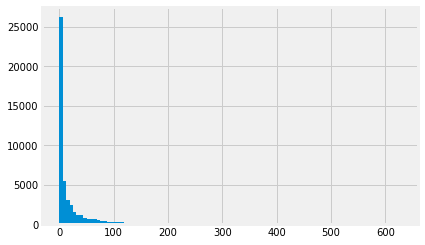

In [10]:
plt.hist(data['number_of_reviews'],bins=100)[2]

In [11]:
#acording to histogram, 'number of reviews'> 200 are outliers, they are replaced with 200
data['number_of_reviews'] = data['number_of_reviews'].apply(lambda x: x if x<=200 else 200)

<a list of 50 Patch objects>

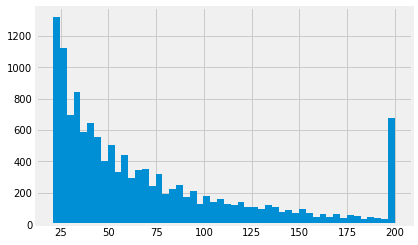

In [12]:
plt.hist(data['number_of_reviews'][data['number_of_reviews']>20],bins=50)[2]

In [13]:
X_df = pd.DataFrame()
for categorical_variable in ['room_type','neighbourhood']:
    X_df = pd.concat([X_df,pd.get_dummies(data[categorical_variable])],axis=1)
    #drop_first=True lead to worse performnse of knn
for contionuous_variable in ['minimum_nights','number_of_reviews','reviews_per_month']:
    X_df = pd.concat([X_df,data[contionuous_variable]],axis=1)

(48884, 228)
(48884,)


<a list of 500 Patch objects>

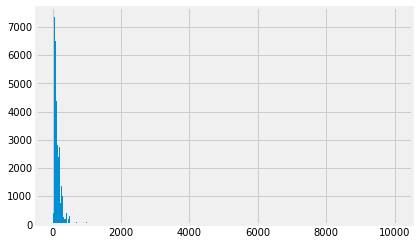

In [14]:
X_df = X_df.reset_index()
print(X_df.shape)
y_ = data['price'].to_numpy()
print(y_.shape)
plt.hist(y_,bins=500)[2]
#we can see that targer data is not distributed normaly, lets transform it

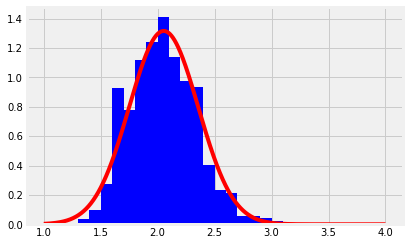

In [15]:
samp = np.log10(y_)
x_ = plt.hist(samp,bins=30,density=True,color='b')
x1 = x_[1][0]
x2 = x_[1][-1]
from scipy.stats import norm
param = norm.fit(samp)
x = np.linspace(x1,x2,48884)
pdf_fitted = norm.pdf(x,loc=param[0],scale=param[1])

plt.plot(x,pdf_fitted,'r-')

In [16]:
y=samp
#so far we finished with all features except text data

## Cleaning text data

In [17]:
# start_time = time.time()

# data.name=data.name.astype(str)
# #1 spliting words by uppercase letter. there are some words fully uppercase, we need to first lowercase them to not confuse with those to split
# data['name'] = data['name'].apply(lambda x: re.sub(r"[^a-zA-Z0-9']+",' ',x))
# from nltk import word_tokenize
# data['name'] = data['name'].apply(lambda x: word_tokenize(x))
# data['name'] = data['name'].apply(lambda x: [word.lower() if word.isupper() else word for word in x])

# import more_itertools as mit
# data['name'] = data['name'].apply(lambda x: [[ "".join(i) for i in mit.split_before(word, pred=lambda s: s.isupper())] for word in x])
# data['name'] = data['name'].apply(lambda x: [[ "".join(i) for i in mit.split_before(word, pred=lambda s: s.isdigit())] for word in x])
# data['name'] = data['name'].apply(lambda x: [j for i in x for j in i])
# data['name'] = data['name'].apply(lambda x: [word.lower()for word in x])

# data['name'] = data['name'].apply(lambda x: [re.split(r'(\d+)', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [j for i in x for j in i])
            
# from nltk.corpus import stopwords
# stop_words = set(stopwords.words('english'))
# data['name'] = data['name'].apply(lambda x: [word for word in x if word not in stop_words])
# data['name'] = data['name'].apply(lambda x: [word for word in x if word !=''])

# from nltk.stem import WordNetLemmatizer
# lem = WordNetLemmatizer()
# data['name'] = data['name'].apply(lambda x: [lem.lemmatize(word,'v') for word in x])
# from nltk.stem import PorterStemmer 
# ps = PorterStemmer()
# data['name'] = data['name'].apply(lambda x: [ps.stem(word) for word in x])

# data['name'] = data['name'].apply(lambda x: [re.sub(r'^ap+[artm]+.*','apt',word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^ro*m','rm',word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^lux.*','lux', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^light.*','light', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^be*d[rm].*','bd', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^ba*th.*','bth', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^b[kr]o*[kl].*','Brooklyn', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^ma*nht+a*n','Manhattan', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^rail.*','train', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^sun.*','sun', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^styl.*','style', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^subw.*','sub', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^up[twnper]*.*','uptwn', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^n[eigh]*b+[hod]*.*','nb', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^b[eau]*t+.*','beaut', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^w[ilia]*[nmsb]+.+','wlmsbrg', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^.*hous.*','house', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^minut','min', word) for word in x])
# data['name'] = data['name'].apply(lambda x: [re.sub(r'^sq[uf].*','sq', word) for word in x])

# for apt in data['name']:
#     for i in range(len(apt)-1):
#         if apt[i].isdigit():
#             apt[i] = apt[i]+apt[i+1]
# data['name'] = data['name'].apply(lambda x: [word for word in x if not word.isdigit()])
# data['name'] = data['name'].apply(lambda x: ' '.join(x))

# pickle.dump(data['name'],open('name_cleared','wb'))
# print("--- %s seconds ---" % (time.time() - start_time))

data['name']=pickle.load(open('name_cleared','rb'))
print(data['name'][:10])

0                     clean quiet apt home park
1                          skylit midtown castl
2                        villag harlem new york
3                    cozi entir floor brownston
4    entir apt spaciou studio loft central park
5             larg cozi 1br br apt midtown east
6                                 blissartsspac
7                    larg furnish rm near b'way
8                cozi clean guest rm famili apt
9              cute cozi lower east side 1bd bd
Name: name, dtype: object


23 seconds

## Extracting words from the cleared text data

In [18]:
# from sklearn.feature_extraction.text import CountVectorizer
# count = CountVectorizer(max_df = 0.1,min_df=0.00003)
# features_name = count.fit_transform(data['name'])
# print(features_name.shape[1])
# print(type(features_name))

# words_df = pd.DataFrame(features_name.toarray(), columns=count.get_feature_names())
# X_all_words = words_df.to_numpy()
# pickle.dump(words_df,open('words_df','wb'))
# pickle.dump(X_all_words,open('X_all_words','wb'))

words_df = pickle.load(open('words_df','rb'))
print(words_df.columns[:10],words_df.columns[3000:3010],words_df.columns[-10:])
#DataFrame containing counts for 3097 words
X_all_words = pickle.load(open('X_all_words','rb'))
#an array containing counts for 3097 words

Index(['000sf', '000sq', '0min', '1000sq', '100night', '100privat', '100sq',
       '105th', '108th', '10br'],
      dtype='object') Index(['walkabl', 'walkup', 'wall', 'war', 'warm', 'warmth', 'warner', 'water',
       'waterfront', 'waterview'],
      dtype='object') Index(['young', 'youth', 'yr', 'yurt', 'zen', 'zero', 'zimmer', 'zona', 'zone',
       'zoo'],
      dtype='object')


## Grouping the words

## Clustering the words:

In [19]:
data["category"] = np.nan

condition = data['price']<150
data['category'][condition]=1
class_1 = data[condition]

condition = (data['price']>=150)&(data['price']<500)
data['category'][condition]=2
class_2 = data[condition]
print(class_2.shape[0])

condition = (data['price']>=500)&(data['price']<1000)
data['category'][condition]=3
class_3 = data[condition]
print(class_3.shape[0])

condition = data['price']>=1000
data['category'][condition]=4
class_4 = data[condition]
print(class_4.shape[0])

each_category_amount = data.groupby('category').count()['id']
print(each_category_amount)

/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18:

15750
937
298
category
1.0    31899
2.0    15750
3.0      937
4.0      298
Name: id, dtype: int64


In [20]:
words_df = pickle.load(open('words_df','rb'))
words_df.head()
# words_category_df = pd.concat([words_df,data.category],axis=1).groupby('category').sum()
# words_category_df_T=words_category_df.T
# pickle.dump(words_category_df_T,open('words_category_df_T','wb'))

,000sf,000sq,0min,1000sq,100night,100privat,100sq,105th,108th,10br,...,young,youth,yr,yurt,zen,zero,zimmer,zona,zone,zoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
words_category_df_T = pickle.load(open('words_category_df_T','rb'))
from sklearn.preprocessing import normalize
words_category_np_T = normalize(words_category_df_T.to_numpy())

# inertia_line = []
from sklearn.cluster import KMeans
# for i in range(1,101):
#     kmeans_i = KMeans(n_clusters=i,init='k-means++',n_jobs=-1)
#     kmeans_i.fit_predict(words_category_np_T)
#     inertia_line.append(kmeans_i.inertia_)
# pickle.dump(inertia_line,open('inertia_KMeans','wb'))

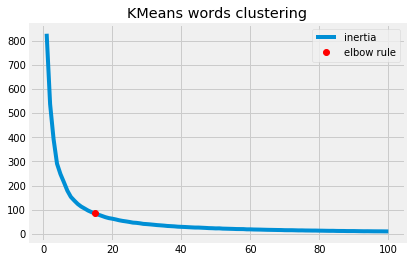

In [22]:
inertia_line = pickle.load(open('inertia_KMeans','rb'))
plt.plot(range(1,101),inertia_line,label='inertia')
plt.plot(15,inertia_line[14],'or',label='elbow rule')
plt.title("KMeans words clustering")
plt.legend()

In [23]:
kmeans_optimal = KMeans(n_clusters=15,init='k-means++',n_jobs=-1)
kmeans_optimal.fit_predict(words_category_df_T.to_numpy())

words_category_df_T['cluster']=kmeans_optimal.labels_

In [24]:
for i in range(1,16):
    X_df['words_cluster_'+str(i)] = words_df[words_category_df_T.index[words_category_df_T['cluster']==i]].sum(axis=1)
    X_df['words_cluster_'+str(i)] = X_df['words_cluster_'+str(i)].fillna(0)
X_df.columns

Index(['index', 'Entire home/apt', 'Private room', 'Shared room', 'Allerton',
       'Arden Heights', 'Arrochar', 'Arverne', 'Astoria', 'Bath Beach',
       ...
       'words_cluster_6', 'words_cluster_7', 'words_cluster_8',
       'words_cluster_9', 'words_cluster_10', 'words_cluster_11',
       'words_cluster_12', 'words_cluster_13', 'words_cluster_14',
       'words_cluster_15'],
      dtype='object', length=243)

## PLS

In [25]:
# start_time = time.time()
# score_all_words = []
# from sklearn.cross_decomposition import PLSRegression
# for i in range(1,16):
#     pls = PLSRegression(n_components=i)
#     pls.fit(X_all_words,y)
#     score_all_words.append(pls.score(X_all_words,y))
#     print('iteration '+str(i)+'/15 is over')
#     pickle.dump(pls, open('pls_words_'+str(i), 'wb'))
# pickle.dump(score_all_words, open('score_all_words', 'wb')) 
# print("--- %s minuts ---" % ((time.time() - start_time)/60))

5 min

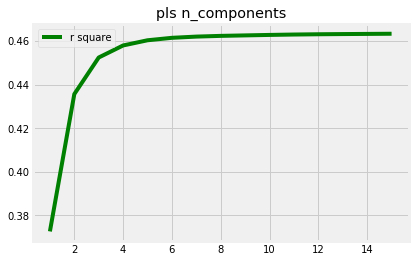

In [26]:
score_all_words = pickle.load(open('score_all_words','rb'))

plt.plot(range(1,16),score_all_words,'g',label = 'r square')
plt.title('pls n_components')
plt.legend()

In [27]:
pls_words_8 = pickle.load(open('pls_words_8','rb'))
X_words, y_pls = pls_words_8.transform(X_all_words,y)

# Regression task

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import GridSearchCV

dict_to_compare_test = {}
dict_to_compare_train = {}

In [29]:
# X_pls = np.concatenate((X_df.to_numpy(),X_words),axis=1)
# X_pls = scaler.fit_transform(X_pls)
# pickle.dump(X_pls,open('X_pls','wb'))

X_pls = pickle.load(open('X_pls','rb'))
num_features = X_pls.shape[1]
X_pls_train, X_pls_test, y_train, y_test = train_test_split(X_pls,y,test_size=0.2,random_state = 3)

In [30]:
from sklearn.linear_model import LassoCV
lr_pls = LassoCV(alphas=[0.0005],cv=4)
lasso_fit = lr_pls.fit(X_pls_train,y_train)
y_lr_pls_train_pred = lr_pls.predict(X_pls_train)
y_lr_pls_test_pred = lr_pls.predict(X_pls_test)
dict_to_compare_train['Linear regression'] = MSE(y_train,y_lr_pls_train_pred)**0.5
dict_to_compare_test['Linear regression'] = MSE(y_test,y_lr_pls_test_pred)**0.5
print(lr_pls.score(X_pls_train,y_train))
print(lr_pls.score(X_pls_test,y_test))

print('lr_pls.alpha_ = ',lr_pls.alpha_)

0.6348528160477831
0.6267994569466386
lr_pls.alpha_ =  0.0005


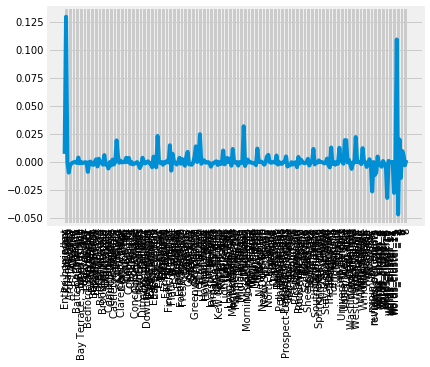

In [31]:
features = np.array(list(X_df.columns)+[1,2,3,4,5,6,7,8])
plt.plot(range(num_features),lasso_fit.coef_)
plt.xticks(range(num_features),features, rotation=90)
plt.show()

In [32]:
features[lasso_fit.coef_==0]

array(['Private room', 'Arverne', 'Astoria', 'Belle Harbor',
       'Bergen Beach', 'Brighton Beach', 'Cambria Heights',
       'Castleton Corners', 'Clason Point', 'Co-op City', 'Columbia St',
       'Coney Island', 'Douglaston', 'East Morrisania', 'Eastchester',
       'Edgemere', 'Eltingville', 'Flatlands', 'Grymes Hill',
       'Jamaica Estates', 'Kew Gardens', 'Lighthouse Hill', 'Little Neck',
       'Manhattan Beach', 'Mariners Harbor', 'Morris Park', 'Neponsit',
       'North Riverdale', 'Olinville', 'Port Richmond', 'Schuylerville',
       'Shore Acres', 'Silver Lake', 'Spuyten Duyvil', 'Todt Hill',
       'Tottenville', 'Westchester Square', 'Westerleigh', 'Whitestone',
       'number_of_reviews', 'words_cluster_11', 'words_cluster_12',
       'words_cluster_13', 'words_cluster_15'], dtype='<U26')

In [33]:
X_pls = X_pls.T[lasso_fit.coef_!=0]
print(X_pls.shape)
X_pls_train, X_pls_test, y_train, y_test = train_test_split(X_pls.T,y,test_size=0.2,random_state = 3)

(207, 48884)


<a list of 500 Patch objects>

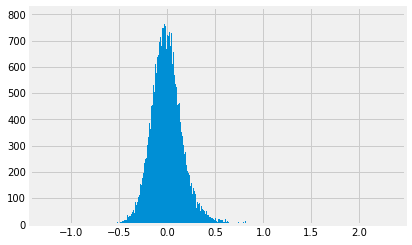

In [34]:
errors = y_train-y_lr_pls_train_pred
plt.hist(errors,bins=500)[2]

### Decision tree regressor

In [35]:
from sklearn.tree import DecisionTreeRegressor
start_time = time.time()

train_line_loss_dt_reg_pls= []
test_line_loss_dt_reg_pls = []

for i in range(1,11):
    dt_i = DecisionTreeRegressor(max_depth=i,random_state=21,min_samples_split=0.0001,min_samples_leaf=0.0001)
    dt_i.fit(X_pls_train,y_train)

    y_dt_reg_pls_train_pred = dt_i.predict(X_pls_train)
    y_dt_reg_pls_test_pred = dt_i.predict(X_pls_test)
    
    train_line_loss_dt_reg_pls.append((MSE(y_train,y_dt_reg_pls_train_pred))**0.5)
    test_line_loss_dt_reg_pls.append((MSE(y_test,y_dt_reg_pls_test_pred))**0.5)
    pickle.dump(dt_i, open('dt_reg_pls_'+str(i), 'wb'))
    print('iteration '+str(i)+'/20 is over')
print("--- %s seconds ---" % (time.time() - start_time))

iteration 1/20 is over
iteration 2/20 is over
iteration 3/20 is over
iteration 4/20 is over
iteration 5/20 is over
iteration 6/20 is over
iteration 7/20 is over
iteration 8/20 is over
iteration 9/20 is over
iteration 10/20 is over
--- 7.16001296043396 seconds ---


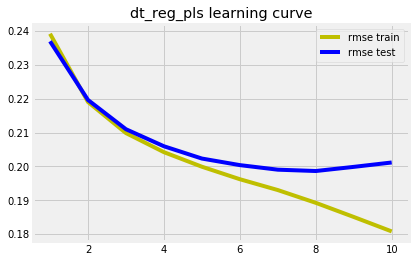

In [36]:
plt.plot(range(1,11),train_line_loss_dt_reg_pls,'y',label = 'rmse train')
plt.plot(range(1,11),test_line_loss_dt_reg_pls,'b', label = 'rmse test')
plt.title('dt_reg_pls learning curve')
plt.legend()

In [37]:
start_time = time.time()
dt_reg_ = DecisionTreeRegressor(random_state=1)
params_dt_reg_ = {'max_depth':[9],
                  'min_samples_leaf':[0.01],
                 'min_samples_split':[0.00001]}
grid_dt = GridSearchCV(estimator=dt_reg_,param_grid=params_dt_reg_,cv=4,n_jobs=-1)
grid_dt.fit(X_pls_train,y_train)
best_model = grid_dt.best_estimator_
pickle.dump(best_model,open('best_model_dt_pls','wb'))
print(grid_dt.best_params_ )
print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model_dt_pls = pickle.load(open('best_model_dt_pls','rb'))
y_dt_gs_train_pred = best_model_dt_pls.predict(X_pls_train)
y_dt_gs_test_pred = best_model_dt_pls.predict(X_pls_test)
dict_to_compare_train['Decision tree'] = MSE(y_train,y_dt_gs_train_pred)**0.5
dict_to_compare_test['Decision tree'] = MSE(y_test,y_dt_gs_test_pred)**0.5
print('rmse train = ',dict_to_compare_train['Decision tree'],'\nrmse test = ',dict_to_compare_test['Decision tree'])

{'max_depth': 9, 'min_samples_leaf': 0.01, 'min_samples_split': 1e-05}
--- 0.04769182999928792 minuts ---
rmse train =  0.1995074204646412 
rmse test =  0.20223240275187257


### Random forest

In [38]:
from  sklearn.ensemble import RandomForestRegressor

start_time = time.time()
train_line_loss_rf = []
test_line_loss_rf = []

for i in range(1,16):
    rf =  RandomForestRegressor(n_estimators=i,random_state=1,min_samples_leaf=0.01,min_samples_split=0.003,max_features=0.07)
    rf.fit(X_pls_train,y_train)
    y_rf_train_pred = rf.predict(X_pls_train)
    y_rf_test_pred = rf.predict(X_pls_test)
    train_line_loss_rf.append((MSE(y_train,y_rf_train_pred))**0.5)
    test_line_loss_rf.append((MSE(y_test,y_rf_test_pred))**0.5)
    print('iteration '+str(i)+'/15 is over')
print("--- %s seconds ---" % (time.time() - start_time))

iteration 1/15 is over
iteration 2/15 is over
iteration 3/15 is over
iteration 4/15 is over
iteration 5/15 is over
iteration 6/15 is over
iteration 7/15 is over
iteration 8/15 is over
iteration 9/15 is over
iteration 10/15 is over
iteration 11/15 is over
iteration 12/15 is over
iteration 13/15 is over
iteration 14/15 is over
iteration 15/15 is over
--- 6.941027879714966 seconds ---


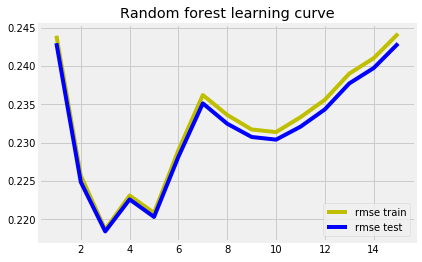

In [39]:
plt.plot(range(1,16),train_line_loss_rf,'y',label = 'rmse train')
plt.plot(range(1,16),test_line_loss_rf,'b', label = 'rmse test')
plt.title('Random forest learning curve')
plt.legend()

In [40]:
# start_time = time.time()
# from  sklearn.ensemble import RandomForestRegressor
# rf_ = RandomForestRegressor(random_state=1)
# params_rf = {'n_estimators':[50],
#              'min_samples_leaf':[0.0001],
#             'min_samples_split':[0.003],
#             'max_features':[0.5]}
# grid_rf = GridSearchCV(estimator=rf_,param_grid=params_rf,cv=4,n_jobs=-1,verbose=1)
# grid_rf.fit(X_pls_train,y_train)
# best_model = grid_rf.best_estimator_
# pickle.dump(best_model,open('best_model_rf','wb'))
# print(grid_rf.best_params_)
# print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model_rf = pickle.load(open('best_model_rf','rb'))
y_rf_gs_train_pred = best_model_rf.predict(X_pls_train)
y_rf_gs_test_pred = best_model_rf.predict(X_pls_test)
dict_to_compare_train['Random forest'] = MSE(y_train,y_rf_gs_train_pred)**0.5
dict_to_compare_test['Random forest'] = MSE(y_test,y_dt_gs_test_pred)**0.5
print('rmse train = ',dict_to_compare_train['Random forest'],'\nrmse test = ',dict_to_compare_test['Random forest'])

Fitting 4 folds for each of 1 candidates, totalling 4 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   4 | elapsed:   28.0s remaining:   28.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   28.9s finished


{'max_features': 0.5, 'min_samples_leaf': 0.0001, 'min_samples_split': 0.003, 'n_estimators': 50}
--- 0.8011480609575907 minuts ---
rmse train =  0.17257498194462337 
rmse test =  0.20223240275187257


### Adaboost

In [41]:
from sklearn.ensemble import AdaBoostRegressor

# train_line_loss_ada = []
# test_line_loss_ada = []

# for i in range(1,16):
#     regr = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=2),random_state=21, n_estimators=i)
#     regr.fit(X_pls_train, y_train)
#     y_ada_train_pred = regr.predict(X_pls_train)
#     y_ada_test_pred = regr.predict(X_pls_test)
#     train_line_loss_ada.append((MSE(y_train,y_ada_train_pred))**0.5)
#     test_line_loss_ada.append((MSE(y_test,y_ada_test_pred))**0.5)
#     print(str(i)+'/15')
# pickle.dump(train_line_loss_ada,open('train_line_loss_ada','wb'))
# pickle.dump(test_line_loss_ada,open('test_line_loss_ada','wb'))

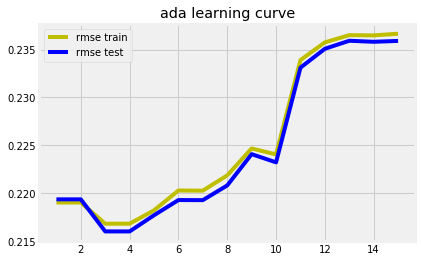

In [42]:
train_line_loss_ada = pickle.load(open('train_line_loss_ada','rb'))
test_line_loss_ada = pickle.load(open('test_line_loss_ada','rb'))
plt.plot(range(1,16),train_line_loss_ada,'y',label = 'rmse train')
plt.plot(range(1,16),test_line_loss_ada,'b', label = 'rmse test')
plt.title('ada learning curve')
plt.legend()

In [43]:
dict_to_compare_train['AdaBoost'] = train_line_loss_ada[3]
dict_to_compare_test['AdaBoost'] = test_line_loss_ada[3]

### Gradient boosting regressor

In [44]:
# from sklearn.ensemble import GradientBoostingRegressor

# start_time = time.time()

# regr = GradientBoostingRegressor(random_state=1)
# params_regr = {'max_depth':[6],
#                   'n_estimators':[150]}
# grid_regr = GridSearchCV(estimator=regr,param_grid=params_regr,cv=4,n_jobs=-1,verbose = 1)
# grid_regr.fit(X_pls_train,y_train)
# best_model = grid_regr.best_estimator_
# pickle.dump(best_model,open('best_model_gb_gs','wb'))
# print(grid_regr.best_params_ )
# print("--- %s minuts ---" % ((time.time() - start_time)/60))

best_model = pickle.load(open('best_model_gb_gs','rb'))
y_grboost_train_pred = best_model.predict(X_pls_train)
y_grboost_test_pred = best_model.predict(X_pls_test)
dict_to_compare_train['GradientBoost'] = MSE(y_train,y_grboost_train_pred)**0.5
dict_to_compare_test['GradientBoost'] = MSE(y_test,y_grboost_test_pred)**0.5

## Summary of regression problem

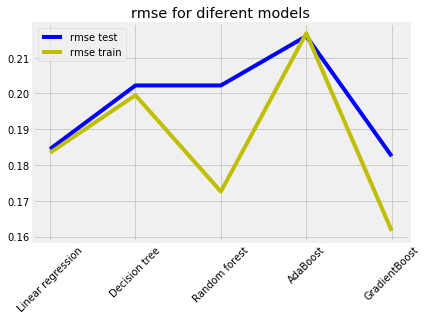

In [45]:
plt.plot(dict_to_compare_test.keys(),dict_to_compare_test.values(),'b',label = 'rmse test')
plt.plot(dict_to_compare_train.keys(),dict_to_compare_train.values(),'y',label='rmse train')
plt.title('rmse for diferent models')
plt.xticks(rotation=45)

plt.legend()

# Classification problem

In [46]:
y_categorical = pd.get_dummies(data.category).to_numpy()
X_train, X_test, y_train_c, y_test_c = train_test_split(X_pls.T,y_categorical,test_size=0.2,random_state = 3)
dict_to_compare_test_c = {}
dict_to_compare_train_c = {}

## KNN

In [47]:
# start_time = time.time()
# from sklearn.neighbors import KNeighborsClassifier

# knn= KNeighborsClassifier()
# params_knn = {'n_neighbors':[1,2],'weights':['distance','uniform']}
# grid_knn = GridSearchCV(estimator=knn,param_grid=params_knn,cv=4,n_jobs=-1,verbose=3,scoring='f1_macro')
# grid_knn.fit(X_train,y_train_c)
# best_model = grid_knn.best_estimator_
# pickle.dump(best_model,open('knn_model','wb'))
# print(grid_knn.best_params_ )
# print("--- %s seconds ---" % (time.time() - start_time))

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 29.9min finished


{'n_neighbors': 1, 'weights': 'distance'}
--- 1801.6215252876282 seconds ---


train f1 macro: 1.0 
test f1 macro: 0.4355814064282347


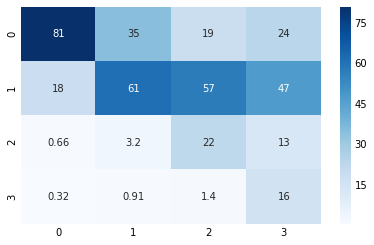

In [48]:
best_model = pickle.load(open('knn_model','rb'))
y_pred = best_model.predict(X_train)
dict_to_compare_train_c['KNN'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='macro')
y_pred = best_model.predict(X_test)
dict_to_compare_test_c['KNN'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='macro')
print('train f1 macro:',dict_to_compare_train_c['KNN'],'\ntest f1 macro:',dict_to_compare_test_c['KNN'])

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
import seaborn as sns
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')

# Decision tree classifier

In [49]:
# start_time = time.time()
# from sklearn.tree import DecisionTreeClassifier

# dt_c= DecisionTreeClassifier()
# params_dt_c = {'max_depth':[10,11,12,13,14,15],
#                   'min_samples_leaf':[0.0005,0.001,0.005],
#                  'min_samples_split':[0.0005,0.001,0.005]}
# grid_dt_c = GridSearchCV(estimator=dt_c,param_grid=params_dt_c,cv=4,n_jobs=-1,verbose=3,scoring='f1_macro')
# grid_dt_c.fit(X_train,y_train_c)
# best_model = grid_dt_c.best_estimator_
# pickle.dump(best_model,open('dt_c','wb'))
# print(grid_dt_c.best_params_ )
# print("--- %s seconds ---" % (time.time() - start_time))

train f1 macro: 0.5079135635500958 
test f1 macro: 0.48415726609157267


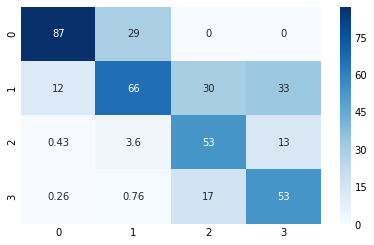

In [50]:
best_model = pickle.load(open('dt_c','rb'))
y_pred = best_model.predict(X_train)
dict_to_compare_train_c['Decision tree'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='macro')
y_pred = best_model.predict(X_test)
dict_to_compare_test_c['Decision tree'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='macro')
print('train f1 macro:',dict_to_compare_train_c['Decision tree'],'\ntest f1 macro:',dict_to_compare_test_c['Decision tree'])

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c.argmax(axis=1), y_pred.argmax(axis=1))
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
import seaborn as sns
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')

## LogisticRegression

In [51]:
X_train, X_test, y_train_c, y_test_c = train_test_split(X_pls.T,data.category,test_size=0.2,random_state = 3)

from sklearn.linear_model import LogisticRegression
start_time = time.time()
log_reg = LogisticRegression(multi_class='ovr')
log_reg.fit(X_train,y_train_c)
print("--- %s seconds ---" % (time.time() - start_time))

/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


--- 13.162949800491333 seconds ---


train f1 macro: 0.4082517524994821 
test f1 macro: 0.40436232995306365


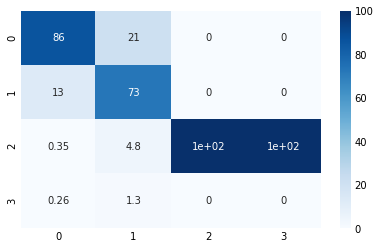

In [52]:
y_pred = log_reg.predict(X_train)
dict_to_compare_train_c['Logistic regression_ovr'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='macro')
y_pred = log_reg.predict(X_test)
dict_to_compare_test_c['Logistic regression_ovr'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='macro')
print('train f1 macro:',dict_to_compare_train_c['Logistic regression_ovr'],'\ntest f1 macro:',dict_to_compare_test_c['Logistic regression_ovr'])

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c, y_pred)
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
import seaborn as sns
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')

In [53]:
from sklearn.linear_model import LogisticRegression
start_time = time.time()
log_reg = LogisticRegression(multi_class='multinomial',solver='saga')
log_reg.fit(X_train,y_train_c)
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.76792049407959 seconds ---


/home/anna/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


train f1 macro: 0.4511642532099926 
test f1 macro: 0.43527519960934524


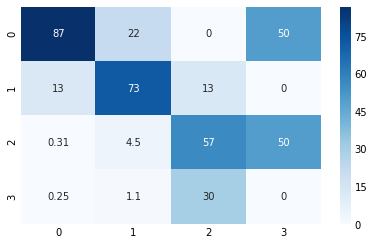

In [54]:
y_pred = log_reg.predict(X_train)
dict_to_compare_train_c['Logistic regression_multinomial'] = sklearn.metrics.f1_score(y_train_c, y_pred,average='macro')
y_pred = log_reg.predict(X_test)
dict_to_compare_test_c['Logistic regression_multinomial'] = sklearn.metrics.f1_score(y_test_c, y_pred,average='macro')
print('train f1 macro:',dict_to_compare_train_c['Logistic regression_multinomial'],'\ntest f1 macro:',dict_to_compare_test_c['Logistic regression_multinomial'])

from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_c, y_pred)
cf_matrix_pc = (cf_matrix/cf_matrix.sum(axis=0))*100
import seaborn as sns
sns.heatmap(cf_matrix_pc, annot=True,cmap='Blues')

## Summary of classification problem

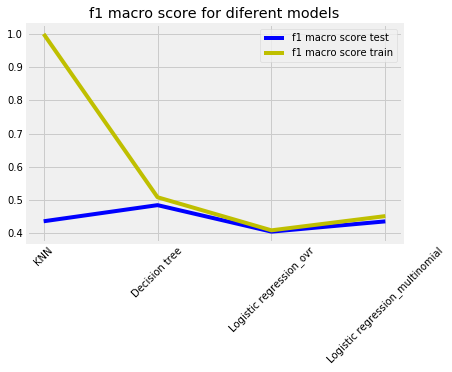

In [55]:
plt.plot(dict_to_compare_test_c.keys(),dict_to_compare_test_c.values(),'b',label = 'f1 macro score test')
plt.plot(dict_to_compare_train_c.keys(),dict_to_compare_train_c.values(),'y',label='f1 macro score train')
plt.title('f1 macro score for diferent models')
plt.xticks(rotation=45)

plt.legend()